# Milestone 2: Baseline Learning with Feed Forward NN
In this notebook, we will train a Feed Forward Neural Network (Also called Multi Layer Perceptron) to predict our target variable.

In [93]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
from google.colab import drive
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
import joblib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings, os
warnings.filterwarnings("ignore")

In [94]:
# mount drive and retrieve pickled data
drive.mount('/content/drive')
datadir = '/content/drive/MyDrive/Colab Notebooks/miso_project/data_pickled/'
df_final = pd.read_pickle(os.path.join(datadir, 'df_final_working.pkl'))
display(df_final.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378 entries, 0 to 21377
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  21378 non-null  datetime64[ns]
 1   Illinois RTLMP Target      21378 non-null  float64       
 2   Arkansas RTLMP             21378 non-null  float64       
 3   Arkansas RTLMP_k23         21378 non-null  float64       
 4   Illinois RTLMP             21378 non-null  float64       
 5   Illinois RTLMP_k1          21378 non-null  float64       
 6   Illinois RTLMP_k2          21378 non-null  float64       
 7   Illinois RTLMP_k3          21378 non-null  float64       
 8   Illinois RTLMP_k23         21378 non-null  float64       
 9   Indiana RTLMP              21378 non-null  float64       
 10  I

None

# Split data
I will split the data chronologically:
- Train: earliest 70%
- Validation: next 15%
- Test: last 15%

We will choose features based on the training data. It is absolutely okay to shuffle the data here since we added lagged features explicitly. But, it would be an unfair comparison against the RNN model. So, we split the data chronologically. However, we may shuffle samples within the training split for SGD efficiency, but never across splits.

In [95]:
n = len(df_final)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)   # 70% + 15%

train_df = df_final.iloc[:train_end].copy()
val_df   = df_final.iloc[train_end:val_end].copy()
test_df  = df_final.iloc[val_end:].copy()

# Scale Data
Recall our observations about the distributions of the features from the previous notebook:

### Loads
**Summary:** The distribution is approximately Gaussian in its central mass but has an additional one-sided tail toward larger load values; the tail is present but less extreme than for prices.

**Interpretation:** This suggests a near-normal baseline demand pattern with some high-load episodes (positive skew). I think regular normalization with mean and standard deviation would suffice. We will use `StandardScaler`.

### Price Features
**Summary**: The distribution has a small mean, with most observations concentrated near the mean, includes some negative values, and exhibits a very long, sparse tail toward larger values.

**Interpretation**: This indicates strong positive skewness, which is maybe driven by occasional extreme high-price events. The presence of negative values also suggest there is a load imbalance in the system. The long right tail implies outliers and non-normality, so we may need robust scaling and/or a transformation. We will use `PowerTransformer(method="yeo-johnson")`, which handles negatives, then `RobustScaler`.


**Summary:** The distribution resembles a Gaussian mixture with two modes, consistent with two underlying regimes (cold-weather and hot-weather conditions).

**Interpretation:** This implies the data are generated by at least two distinct temperature regimes rather than a single unimodal process. However, I will use a naive normalization for these data. We will use `StandardScaler`.

In [96]:
TARGET_COL = "Illinois RTLMP Target"

PRICE_COLS = [
    "Arkansas RTLMP", "Arkansas RTLMP_k23",
    "Illinois RTLMP", "Illinois RTLMP_k1", "Illinois RTLMP_k2", "Illinois RTLMP_k3", "Illinois RTLMP_k23",
    "Indiana RTLMP", "Indiana RTLMP_k23",
    "Michigan RTLMP", "Michigan RTLMP_k23",
    "Arkansas DALMP_k-1", "Illinois DALMP_k-1", "Indiana DALMP_k-1", "Michigan DALMP_k-1",
]

LOAD_COLS = [
    "Total Actual Load",
    "Total Forecast Load_k-1",
    "LRZ 4_forecast_k-1",
    "LRZ 8_ 9_ 10_forecast_k-1",
]

TEMP_COLS = [
    "Argonne_temp_k-1",
    "Indianapolis_temp_k-1",
]

CYC_COLS = [
    "week_sin_k-1", "week_cos_k-1",
    "hour_sin_k-1", "hour_cos_k-1",
    "month_sin_k-1", "month_cos_k-1",
]

Let's split features and target, and drop Timestamp.

In [97]:
X_train = train_df.drop(columns=["Timestamp", TARGET_COL]).copy()
y_train = train_df[TARGET_COL].copy()

X_val = val_df.drop(columns=["Timestamp", TARGET_COL]).copy()
y_val = val_df[TARGET_COL].copy()

X_test = test_df.drop(columns=["Timestamp", TARGET_COL]).copy()
y_test = test_df[TARGET_COL].copy()

Define the data processing pipelines:

In [98]:
price_pipe = Pipeline(steps=[
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("robust", RobustScaler()),
])

load_pipe = Pipeline(steps=[
    ("std", StandardScaler()),
])

temp_pipe = Pipeline(steps=[
    ("std", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("price", price_pipe, PRICE_COLS),
        ("load",  load_pipe,  LOAD_COLS),
        ("temp",  temp_pipe,  TEMP_COLS),
        ("cyc",   "passthrough", CYC_COLS),
    ],
    remainder="drop"
)

y_scaler = Pipeline(steps=[
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("robust", RobustScaler()),
])

We will fit only on the training set to prevent data leakage. For the rest, we will only transform based on our training data fit.  Note that we will later use `y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()` to inverse our transform.

In [99]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled   = preprocessor.transform(X_val)
X_test_scaled  = preprocessor.transform(X_test)

# Target variable
y_train_scaled = y_scaler.fit_transform(y_train.to_frame()).ravel()
y_val_scaled   = y_scaler.transform(y_val.to_frame()).ravel()
y_test_scaled  = y_scaler.transform(y_test.to_frame()).ravel()

In [100]:
joblib.dump(preprocessor, "X_preprocessor.joblib")
joblib.dump(y_scaler, "y_scaler.joblib")

dataset_scaled = {
    "X_train": X_train_scaled, "y_train": y_train_scaled,
    "X_val":   X_val_scaled,   "y_val":   y_val_scaled,
    "X_test":  X_test_scaled,  "y_test":  y_test_scaled,
}

joblib.dump(dataset_scaled, "dataset_scaled.joblib")

print("Done.")
print("Shapes:")
print("X_train:", X_train_scaled.shape, "y_train:", y_train_scaled.shape)
print("X_val:  ", X_val_scaled.shape,   "y_val:  ", y_val_scaled.shape)
print("X_test: ", X_test_scaled.shape,  "y_test: ", y_test_scaled.shape)


Done.
Shapes:
X_train: (14964, 27) y_train: (14964,)
X_val:   (3207, 27) y_val:   (3207,)
X_test:  (3207, 27) y_test:  (3207,)


# Training the NN Model

In [101]:
# Let's make sure the project is reproducable
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Discussion on Evaluation of Success and Model
We have hourly time series, feedforward NN, and heavy-tailed prices.
### Metric for prediction success
I will report Report both MAE and RMSE (in $/MWh) after inverse-transforming predictions back to original price units. Because both are very interpretable. MAE is robust to outliers compared to RMSE so it will explain our success on average days. RMSE penalizes large misses more. This shows whether spikes are being badly missed. In particular, we early-stop on validation MAE to prioritize typical-hour accuracy, and report RMSE to quantify spike sensitivity.

### Model

**Algorithm:** We will use Multi Layer Perceptron (MLP) because our input is fixed-length tabular features. Our features are already scaled, and the relationships are nonlinear. MLP is a fast and stable model. We will use `batch_size = 256` and `max_epochs` = 200. These are very typical values. We have early stopping so we will not tune `max_epochs`.


**Activation:** `LeakyReLU(negative_slope=0.01)` to avoid dying RELUs. It doesn't exactly prevent vanishing gradients, but we won't have a deep NN anyway. It is also very fast beacuse it is piecewise linear.

**Architecture:** We will have 3 hidden layers, e.g. 256 ->  256 -> 128, then 1 output neuron. We don't have that many features compared to a typical deep learning task. 1-4 hidden layers are enough the capture nonlinearity. We will have `BatchNorm` after each Linear layer (before activation). BatchNorm normalizes hidden activations while training. This stabilizes training, reduces sensitivity to initialization and learning rate, and often improves convergence for multi-layer MLPs. Also, we will use `Dropout(p=0.1-0.2)` between hidden layers. Because our target has rare spikes and regime changes;thus, an MLP can overfit patterns that are specific to the training period.
Overall our block per layer is: Linear -> BatchNorm -> LeakyReLU -> Dropout, excluding the output layer.

**Optimizer:** We will use `AdamW(lr=1e-3, weight_decay=1e-4)`. We can change `weight_decay = 1e-5` if think we are underfitting.  We use this over `Adam` because AdamW decouples the weight decay from the from the gradient-based update, making regularization more consistent and easier to tune.
Also, we use `ReduceLROnPlateau` validation MAE to lower the learning rate when progress stalls.

**Regularization:** We use weight decay (via AdamW) + dropout + earlystopping.
AdamW is the optimizer; weight_decay is the regularizer.

**Choice of cost function:** We want our training objective not to get dominated by rare price spikes, while still learning them. Also, stable for training. This shouts Huber loss, which behaves like MSE near zero error and like MAE for large errors.

 Overall our design choices are these:
 - Loss: Huber
 - Metrics (reported): MAE + RMSE in $/MWh (inverse-transformed)
 - Early stopping: validation MAE (patience=20)
 - Optimizer: AdamW(lr=1e-3, weight_decay=1e-4)
 - Scheduler: ReduceLROnPlateau on validation MAE
 - Architecture: (Linear -> BatchNorm -> LeakyReLU -> Dropout) x 3 + output Linear





In [102]:
# Hyperparameters
batch_size = 256
max_epochs = 200
patience = 40
lr = 1e-3
weight_decay = 1e-4
dropout_p = 0.15
negative_slope = 0.01
grad_clip = 1.0

In [103]:
# Dataset
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train_scaled, y_train_scaled)
val_ds   = TabularDataset(X_val_scaled, y_val_scaled)
test_ds  = TabularDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

In [104]:
#  Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(256, 256, 128), dropout=0.15, neg_slope=0.01):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.LeakyReLU(negative_slope=neg_slope))
            layers.append(nn.Dropout(p=dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))  # output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

input_dim = X_train_scaled.shape[1]
model = MLP(input_dim=input_dim, hidden_dims=(256, 256, 128), dropout=dropout_p, neg_slope=negative_slope).to(device)

#  Loss, optimizer, scheduler
criterion = nn.HuberLoss(delta=1.0)  # Huber on scaled target
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-5
)

#  Helpers
@torch.no_grad()
def predict_scaled(dataloader):
    model.eval()
    preds = []
    trues = []
    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.to(device)
        yhat = model(xb)
        preds.append(yhat.detach().cpu().numpy())
        trues.append(yb.detach().cpu().numpy())
    return np.concatenate(preds), np.concatenate(trues)

def inverse_y(y_scaled_1d):
    # y_scaler expects shape (n, 1)
    return y_scaler.inverse_transform(y_scaled_1d.reshape(-1, 1)).ravel()

In [105]:
# Training loop with early stopping on validation MAE
best_val_mae = float("inf")
best_state = None
epochs_no_improve = 0

for epoch in range(1, max_epochs + 1):
    model.train()
    running_loss = 0.0
    n_seen = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
        optimizer.step()

        bs = xb.size(0)
        running_loss += loss.item() * bs
        n_seen += bs

    train_loss = running_loss / max(1, n_seen)

    # Validation metrics in ORIGINAL units
    val_pred_scaled, val_true_scaled = predict_scaled(val_loader)
    val_pred = inverse_y(val_pred_scaled)
    val_true = inverse_y(val_true_scaled)  # or use y_val.values if you prefer exact originals

    val_mae = mean_absolute_error(val_true, val_pred)
    val_rmse = np.sqrt(mean_squared_error(val_true, val_pred))

    scheduler.step(val_mae)

    print(
        f"Epoch {epoch:03d} | "
        f"Train Huber (scaled): {train_loss:.4f} | "
        f"Val MAE ($/MWh): {val_mae:.4f} | "
        f"Val RMSE ($/MWh): {val_rmse:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e}"
    )

    # Early stopping on validation MAE
    if val_mae < best_val_mae - 1e-6:
        best_val_mae = val_mae
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best Val MAE: {best_val_mae:.4f}")
            break

# Load best checkpoint
if best_state is not None:
    model.load_state_dict(best_state)

# Final test evaluation (original units)
test_pred_scaled, test_true_scaled = predict_scaled(test_loader)
test_pred = inverse_y(test_pred_scaled)
test_true = inverse_y(test_true_scaled)  # or use y_test.values

test_mae = mean_absolute_error(test_true, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_true, test_pred))

print(f"\nBest Val MAE ($/MWh): {best_val_mae:.4f}")
print(f"Test MAE ($/MWh): {test_mae:.4f}")
print(f"Test RMSE ($/MWh): {test_rmse:.4f}")

# (Optional) save model
torch.save(model.state_dict(), "mlp_best.pt")


Epoch 001 | Train Huber (scaled): 0.1348 | Val MAE ($/MWh): 10.1556 | Val RMSE ($/MWh): 59.7992 | LR: 1.00e-03
Epoch 002 | Train Huber (scaled): 0.1052 | Val MAE ($/MWh): 11.0457 | Val RMSE ($/MWh): 64.0658 | LR: 1.00e-03
Epoch 003 | Train Huber (scaled): 0.1005 | Val MAE ($/MWh): 10.0803 | Val RMSE ($/MWh): 59.6087 | LR: 1.00e-03
Epoch 004 | Train Huber (scaled): 0.0968 | Val MAE ($/MWh): 9.6782 | Val RMSE ($/MWh): 56.2343 | LR: 1.00e-03
Epoch 005 | Train Huber (scaled): 0.0954 | Val MAE ($/MWh): 10.0852 | Val RMSE ($/MWh): 59.8088 | LR: 1.00e-03
Epoch 006 | Train Huber (scaled): 0.0958 | Val MAE ($/MWh): 10.0036 | Val RMSE ($/MWh): 60.2375 | LR: 1.00e-03
Epoch 007 | Train Huber (scaled): 0.0930 | Val MAE ($/MWh): 9.8935 | Val RMSE ($/MWh): 59.0613 | LR: 1.00e-03
Epoch 008 | Train Huber (scaled): 0.0936 | Val MAE ($/MWh): 9.8735 | Val RMSE ($/MWh): 54.2077 | LR: 1.00e-03
Epoch 009 | Train Huber (scaled): 0.0919 | Val MAE ($/MWh): 10.1142 | Val RMSE ($/MWh): 60.3443 | LR: 1.00e-03
Epoc

Our test error is better than the validation error. However, we split the data chronologically. If the validation period has more spikes / higher variance than test, our numbers are consistent. Below shows that this is true.

In [106]:
def describe(name, y):
    y = np.asarray(y)
    print(
        f"{name}: n={len(y)} mean={y.mean():.2f} std={y.std():.2f} "
        f"min={y.min():.2f} p95={np.percentile(y,95):.2f} "
        f"p99={np.percentile(y,99):.2f} max={y.max():.2f}"
    )

describe("TRAIN", y_train.values)
describe("VAL",   y_val.values)
describe("TEST",  y_test.values)

TRAIN: n=14964 mean=50.95 std=40.98 min=-49.24 p95=112.98 p99=200.10 max=1070.04
VAL: n=3207 mean=41.10 std=73.49 min=-74.95 p95=76.66 p99=171.11 max=2178.34
TEST: n=3207 mean=26.21 std=19.44 min=-25.28 p95=48.72 p99=107.96 max=341.12


# Predictions vs actual prices

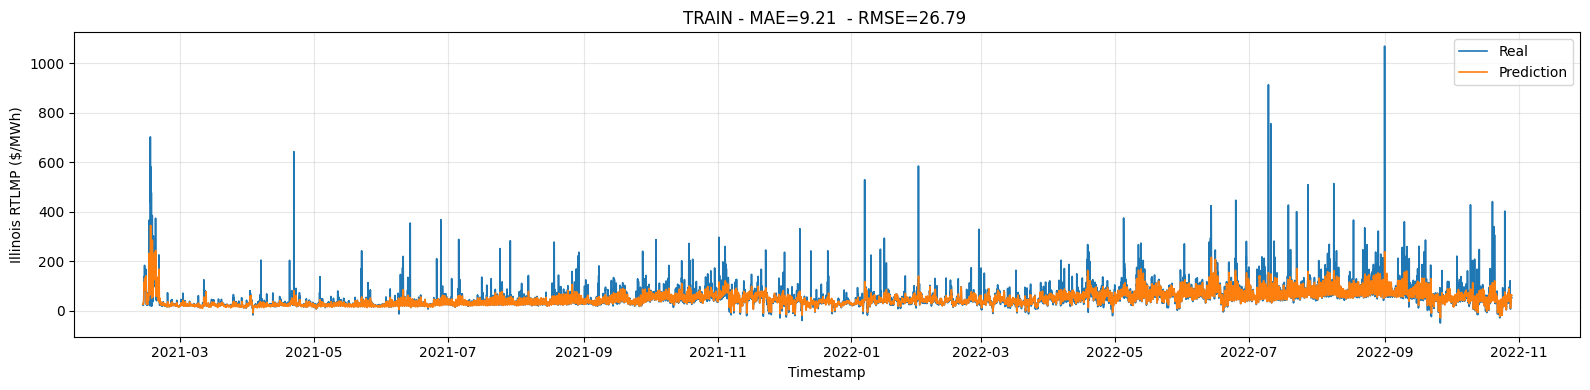

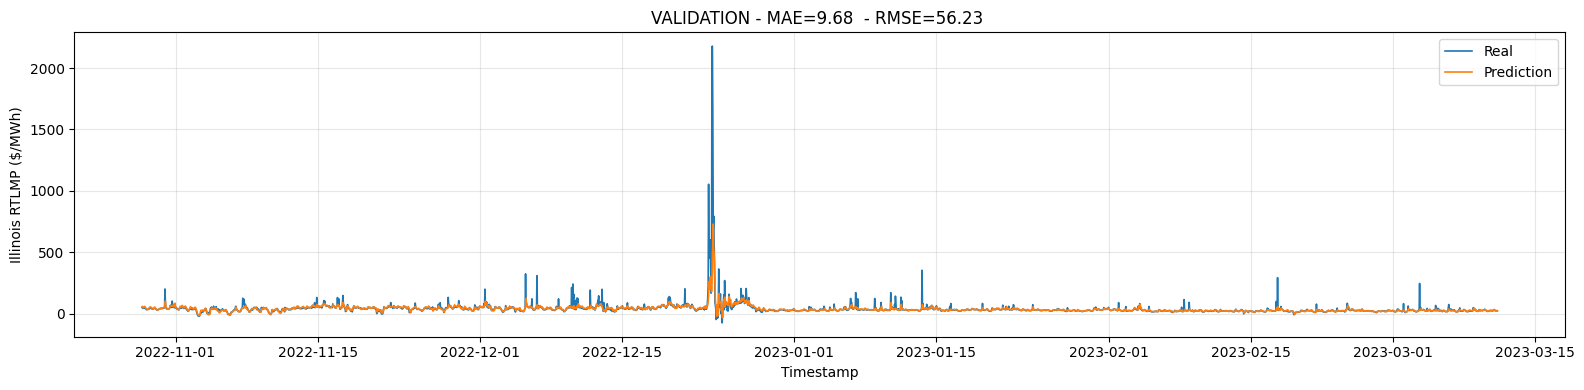

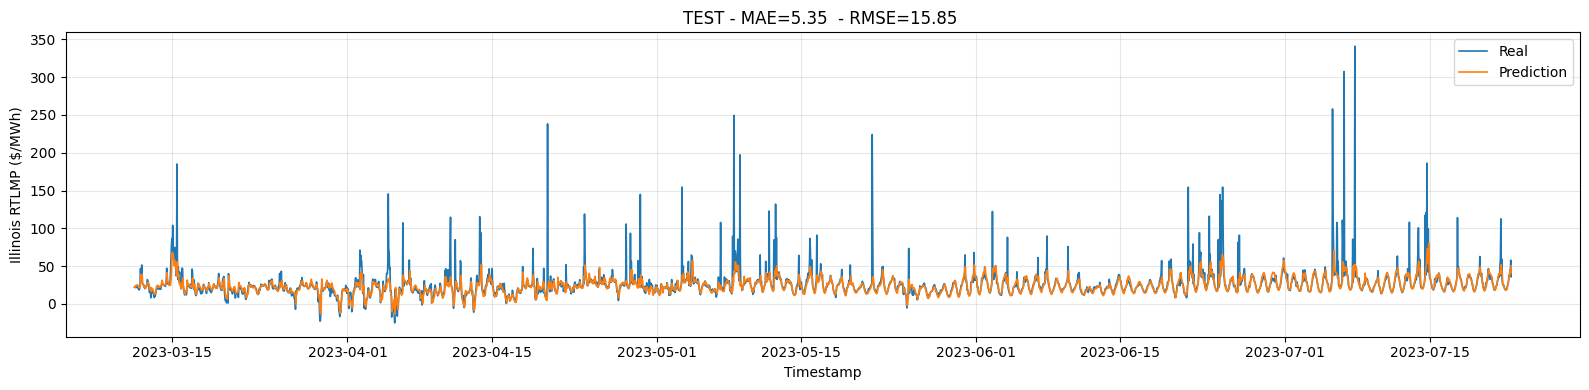

In [107]:
# Helper: predict (scaled) then inverse-transform to $/MWh
@torch.no_grad()
def predict_in_dollars(X_scaled, batch_size=4096):
    model.eval()
    X_scaled = np.asarray(X_scaled)
    preds = []

    for i in range(0, len(X_scaled), batch_size):
        xb = torch.tensor(X_scaled[i:i+batch_size], dtype=torch.float32, device=device)
        yhat_scaled = model(xb).detach().cpu().numpy()
        preds.append(yhat_scaled)

    yhat_scaled = np.concatenate(preds, axis=0)
    yhat = y_scaler.inverse_transform(yhat_scaled.reshape(-1, 1)).ravel()
    return yhat

def plot_split(ts, y_true, y_pred, split_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    plt.figure(figsize=(16, 4))
    plt.plot(ts, y_true, label="Real", linewidth=1.2)
    plt.plot(ts, y_pred, label="Prediction", linewidth=1.2)

    plt.title(f"{split_name} - MAE={mae:.2f}  - RMSE={rmse:.2f} ")
    plt.xlabel("Timestamp")
    plt.ylabel("Illinois RTLMP ($/MWh)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Predictions ---
train_pred = predict_in_dollars(X_train_scaled)
val_pred   = predict_in_dollars(X_val_scaled)
test_pred  = predict_in_dollars(X_test_scaled)

# --- True values in $/MWh (use original y_* series) ---
train_true = y_train.values
val_true   = y_val.values
test_true  = y_test.values

# --- Timestamps (aligned with X_*_scaled / y_*) ---
train_ts = train_df["Timestamp"].values
val_ts   = val_df["Timestamp"].values
test_ts  = test_df["Timestamp"].values

# --- Plots (separate) ---
plot_split(train_ts, train_true, train_pred, "TRAIN")
plot_split(val_ts,   val_true,   val_pred,   "VALIDATION")
plot_split(test_ts,  test_true,  test_pred,  "TEST")


We are doing a very bad job predicting the spikes. We will change the early stoping to RMSE on the validation set. Also we will change the cost function to RMSE.